In [1]:
seed = 123

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm as cm

In [3]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.sans-serif": ["computer modern roman"]})
    
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times'],
    'text.usetex': True,
})

In [4]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, balanced_accuracy_score
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE
from sklearn.linear_model import LogisticRegression

In [5]:
import shap, os, pickle

In [6]:
from datetime import datetime
def getTime(): print(datetime.now().strftime("%H:%M:%S"))

# Script

In [7]:
def findParameters(Xtrain, ytrain, n_seed, iter_n=100, version='lgbm', rerun=False):
    getTime()
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('over', 'passthrough'),
        ('clf', 'passthrough'),
    ])
    params = {
        'lgbm': [{
            'over':[
                RandomOverSampler(random_state=n_seed),
                SMOTE(random_state=n_seed, k_neighbors=3),],
            'over__sampling_strategy': ('minority', 'not minority', 
                                        'not majority', 'all'),
            'clf': [LGBMClassifier(random_state=n_seed)],
            'clf__n_estimators': [50, 100, 150, 200],
            'clf__colsample_bytree': [0.7, 0.8],
            'clf__max_depth': [5, 10, 15, 20, 25],
            'clf__num_leaves': [25, 50, 100, 200],
            'clf__reg_alpha': [0.1, 0.5, 1.1, 1.2, 1.3],
            'clf__reg_lambda': [1.1, 1.2, 1.3],
            'clf__min_split_gain': [0.3, 0.4],
            'clf__subsample': [0.7, 0.8, 0.9],
            'clf__subsample_freq': [0, 20],
            'clf__class_weight': ['balanced', None]}],
        'logistic': [{
            'over':[
                RandomOverSampler(random_state=n_seed),
                SMOTE(random_state=n_seed, k_neighbors=3)],
            'over__sampling_strategy': ('minority', 'not minority', 'not majority', 'all'),
            'clf': [LogisticRegression(random_state=n_seed)],
            'clf__class_weight': ['balanced', None],
            'clf__multi_class': ['multinomial', 'ovr'],
            # 'clf__penalty' : ['l2'],
            # 'clf__C' : np.logspace(-4, 4, 7),
        }]
    }
    
    pkl_str = f'../data/aux/gridsearch_{iter_n}_{version}.pkl'
    if os.path.isfile(pkl_str) and not rerun:
        with open(pkl_str, 'rb') as handle:
            gridsearch = pickle.load(handle)
            
    else: 
        # gridsearch = GridSearchCV(
        gridsearch = RandomizedSearchCV(
            pipe, params[version], n_jobs=7, scoring='%s_macro' % 'f1', verbose=1,
            cv=RepeatedStratifiedKFold(n_splits=2, random_state=n_seed), 
            error_score='raise', random_state=n_seed, n_iter=iter_n).fit(Xtrain, ytrain)
        
        with open(pkl_str, 'wb') as handle:
            pickle.dump(gridsearch, handle, 
                        protocol=pickle.HIGHEST_PROTOCOL)
    
    getTime()        
    return gridsearch

In [8]:
def printShapes(pipe, X, y, feat=False):
    print(f"input\t{X.shape}\n{y.value_counts()}\n")
    _over, _y = pipe.named_steps['over'].fit_resample(X, y)
    print(f"over\t{_over.shape}\n{_y.value_counts()}")

In [9]:
def plotConfusion(model, X, y, title):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3), dpi=100)
    plot_confusion_matrix(model, X, y, ax=ax, cmap=plt.cm.Greys) 
    ax.set_title(title)

In [10]:
def printReport(search, train, test):
    print("\n##########\n# treino #\n##########\n"); printShapes(search.best_estimator_, *train)
    print("\nparâmetros"); pprint(search.best_params_)
    print("\nmatrix\n", classification_report(test[1],search.best_estimator_.predict(test[0])))
    print("\ntrain"); ConfusionMatrixDisplay.from_estimator(search.best_estimator_, *train, cmap=plt.cm.Greys); plt.show()
    print("\ntest"); ConfusionMatrixDisplay.from_estimator(search.best_estimator_, *test, cmap=plt.cm.Greys); plt.savefig("../figs/confusion.pdf", bbox_inches='tight')

# Run

In [11]:
# prepare data
data = pd.read_csv('../data/dataset.csv', index_col=0).sample(frac=1, random_state=seed)
selection = data.copy()[data.index.str[:4].astype(int)<2019]#.drop(['AR', 'YUR', 'LTU'], axis=1)
X, y = selection.drop('label', axis=1).sort_index(axis=1), selection.label.replace(0,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=seed)

# find best model
gs = findParameters(X_train, y_train, seed, iter_n=20000)# version='logistic', rerun=True) #20000

16:19:39
16:19:39


In [12]:
from sklearn import set_config
set_config(display="diagram")
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('over',
                 SMOTE(k_neighbors=3, random_state=123,
                       sampling_strategy='not majority')),
                ('clf',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
                                max_depth=25, min_split_gain=0.3,
                                n_estimators=150, num_leaves=100,
                                random_state=123, reg_alpha=0.1, reg_lambda=1.1,
                                subsample=0.8, subsample_freq=20))])

In [13]:
print('Sample size, per category:')
y.value_counts()

Sample size, per category:


1    96
2    72
3    28
4    18
Name: label, dtype: int64


##########
# treino #
##########

input	(160, 14)
1    74
2    54
3    21
4    11
Name: label, dtype: int64

over	(296, 14)
3    74
2    74
1    74
4    74
Name: label, dtype: int64

parâmetros
{'clf': LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, max_depth=25,
               min_split_gain=0.3, n_estimators=150, num_leaves=100,
               random_state=123, reg_alpha=0.1, reg_lambda=1.1, subsample=0.8,
               subsample_freq=20),
 'clf__class_weight': 'balanced',
 'clf__colsample_bytree': 0.7,
 'clf__max_depth': 25,
 'clf__min_split_gain': 0.3,
 'clf__n_estimators': 150,
 'clf__num_leaves': 100,
 'clf__reg_alpha': 0.1,
 'clf__reg_lambda': 1.1,
 'clf__subsample': 0.8,
 'clf__subsample_freq': 20,
 'over': SMOTE(k_neighbors=3, random_state=123, sampling_strategy='not majority'),
 'over__sampling_strategy': 'not majority'}

matrix
               precision    recall  f1-score   support

           1       0.77      0.91      0.83        22
           2       0.92

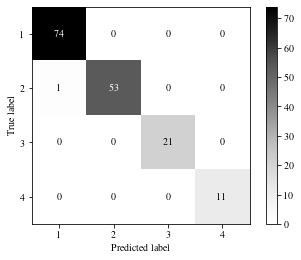


test


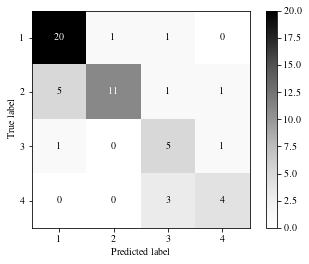

In [14]:
printReport(gs, [X_train, y_train], [X_test, y_test])

In [15]:
balanced_accuracy_score(y_test, gs.best_estimator_.predict(X_test))

0.7014790764790766

# Plots

In [16]:
classes = ['No Imbalance', 'Imbalance', 'Excessive Imbalance', 'Excessive Imbance with Corrective Action']
# classes = ['Sem desequilíbrios', 'Desequilíbrios', 'Desequilíbrios excessivos', 'Desequilíbrios excessivos\ncom ação corretiva']

In [17]:
X_shap = pd.DataFrame(gs.best_estimator_.named_steps['scaler'].transform(X), index=X.index, columns=X.columns)

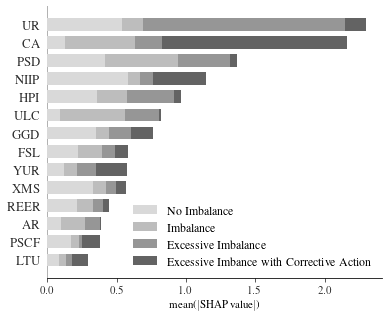

In [18]:
# fig = plt.figure(dpi=100)
explainer = shap.TreeExplainer(gs.best_estimator_.named_steps['clf'])
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap, plot_type="bar", plot_size=(6,5), 
                  color=plt.get_cmap('tab20c_r'), class_names=classes, class_inds=[0,1,2,3], show=False)
plt.gca().set_xlabel(r'mean($\mid$SHAP value$\mid$)', 
                     fontsize=11)
plt.gcf().savefig("../figs/features.pdf", bbox_inches='tight')
plt.show()

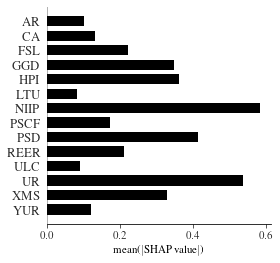

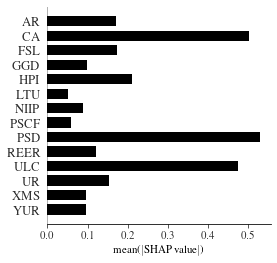

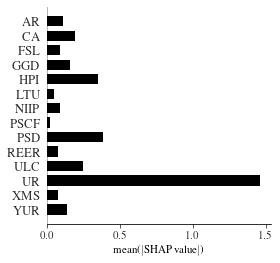

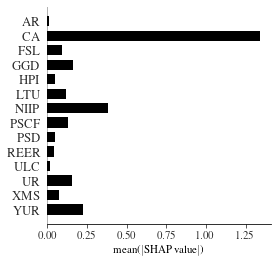

In [19]:
for i in range(4):
    shap.summary_plot(shap_values[i], X_shap, 
                      plot_type="bar", color='k', 
                      show=False, sort=False, plot_size=(4,4))
    plt.gca().set_xlabel(r'mean($\mid$SHAP value$\mid$)', fontsize=11)
    plt.gcf().savefig(f"../figs/classes_{i+1}.pdf", bbox_inches='tight')
    plt.show()

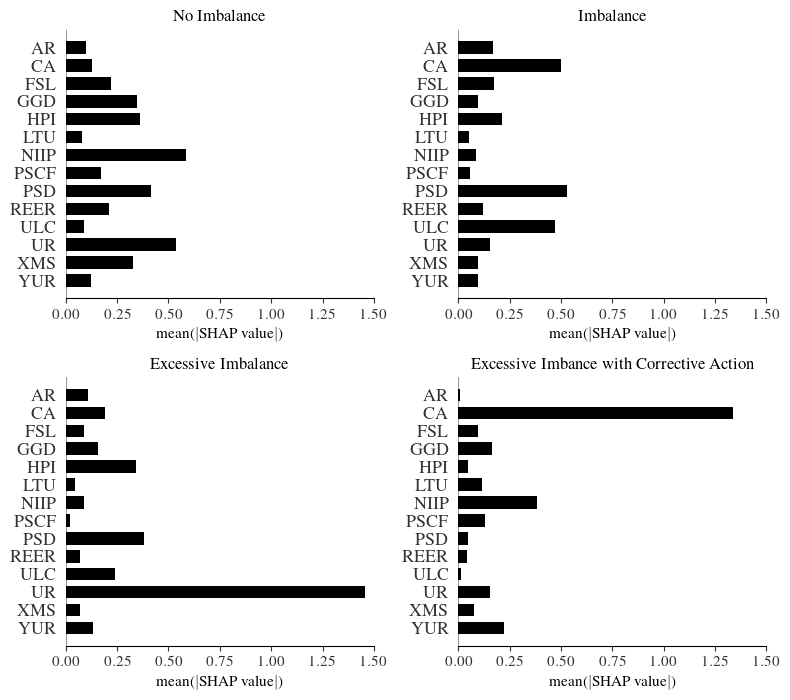

In [20]:
  # joint
fig = plt.figure(figsize=(5,5), dpi=100)

for i, x in enumerate(classes):
    ax2 = fig.add_subplot(220+(i+1))
    ax2.title.set_text(x)
    shap.summary_plot(shap_values[i], X_shap, plot_type="bar", color='k', show=False, sort=False)
    plt.xlim(0,1.5)
    ax2.set_xlabel(r'mean($\mid$SHAP value$\mid$)', fontsize=11)
    
# plt.tight_layout(pad=3) # You can also use plt.tight_layout() instead of using plt.subplots_adjust() to add space between plots
plt.tight_layout()
fig.savefig("../figs/classes.pdf", bbox_inches='tight')
plt.show()

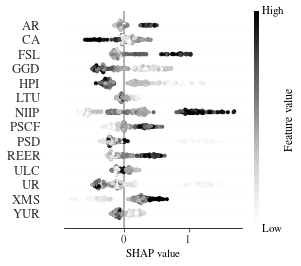

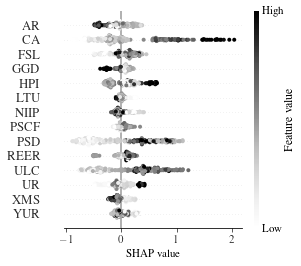

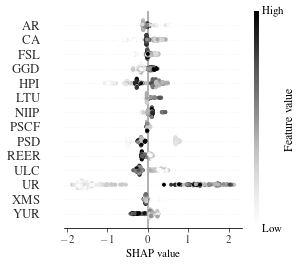

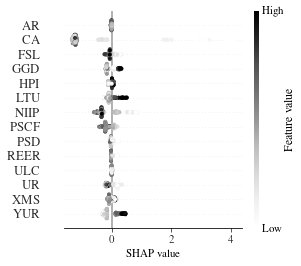

In [21]:
for i in range(4):
    shap.summary_plot(shap_values[i], X_shap, show=False, 
                      sort=False,  cmap=plt.get_cmap('Greys'), 
                      plot_size=(4,4))
    plt.gca().set_xlabel('SHAP value', fontsize=11)
    plt.gcf().savefig(f"../figs/distribution_{i+1}.pdf", bbox_inches='tight')
    plt.show()

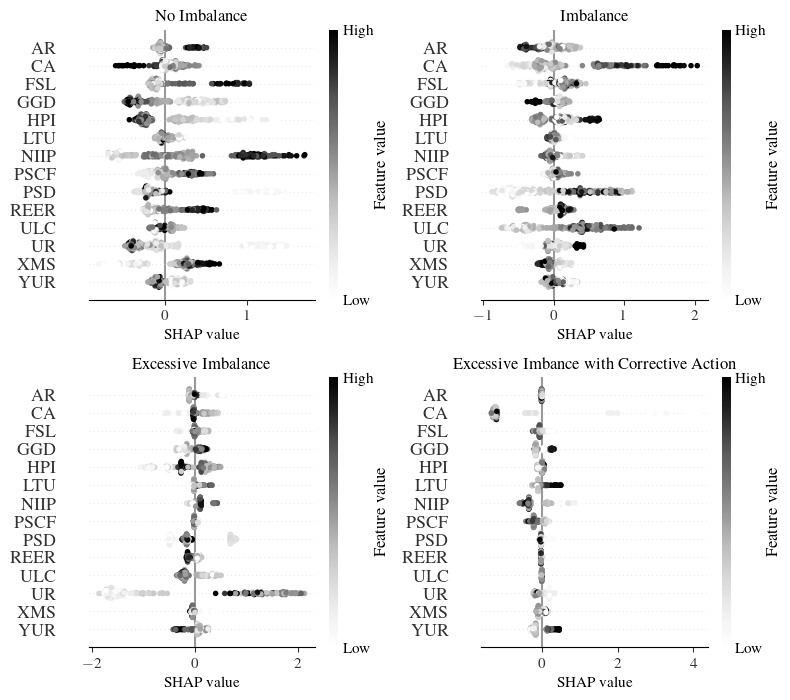

In [22]:
fig = plt.figure(figsize=(5,5), dpi=100)
for i, x in enumerate(classes):
    ax2 = fig.add_subplot(220+(i+1))
    ax2.title.set_text(x)
    shap.summary_plot(shap_values[i], X_shap, show=False, sort=False,  cmap=plt.get_cmap('Greys'), )
    # plt.xlim(-2,2)
    ax2.set_xlabel('SHAP value', fontsize=11)
# plt.tight_layout(pad=3) # You can also use plt.tight_layout() instead of using plt.subplots_adjust() to add space between plots
plt.tight_layout()
fig.savefig("../figs/distribution.pdf", bbox_inches='tight')
plt.show()

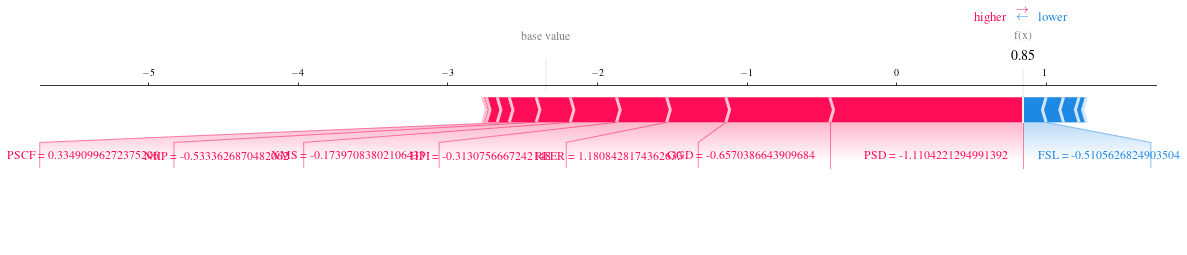

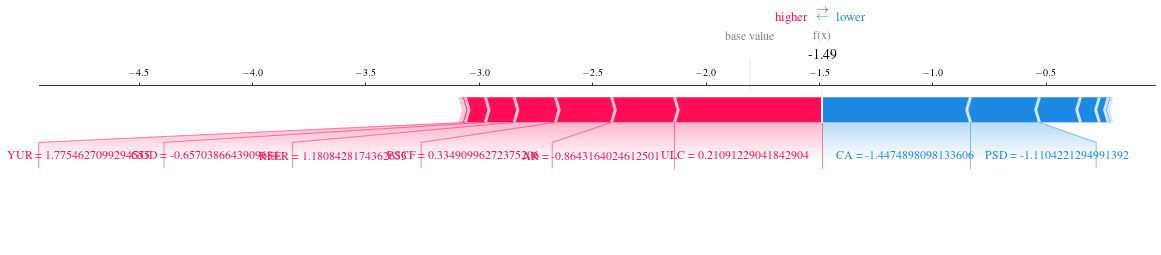

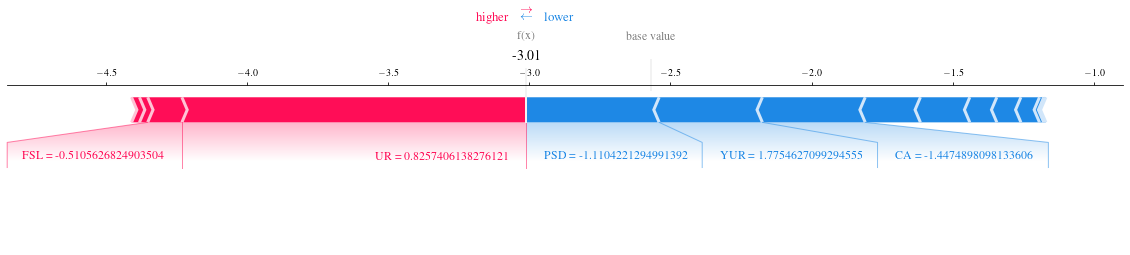

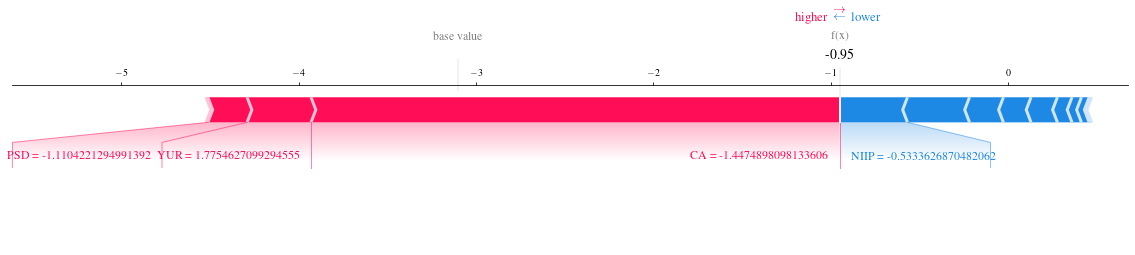

In [23]:
for mip in range(4):
    shap.force_plot(explainer.expected_value[mip],
                    shap_values[mip][y.index=='2011_SK'], 
                    X_shap.loc['2011_SK'], 
                    show=True, matplotlib=True)

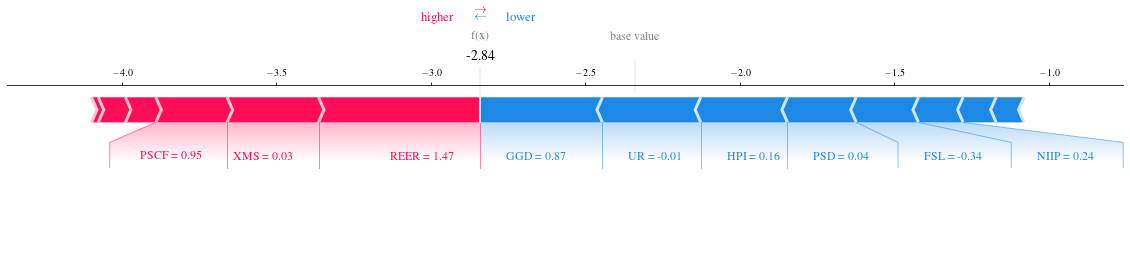

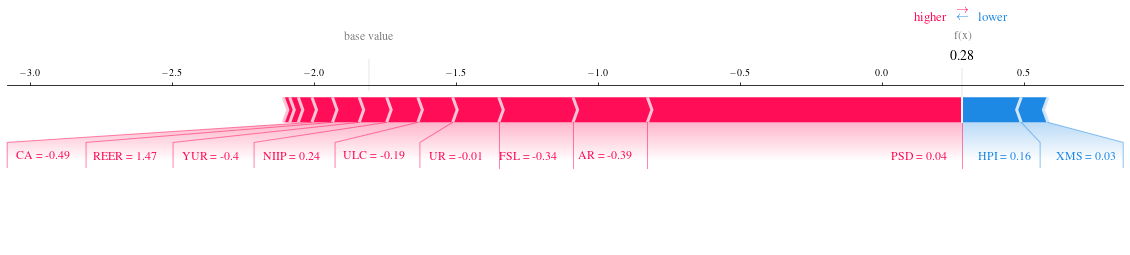

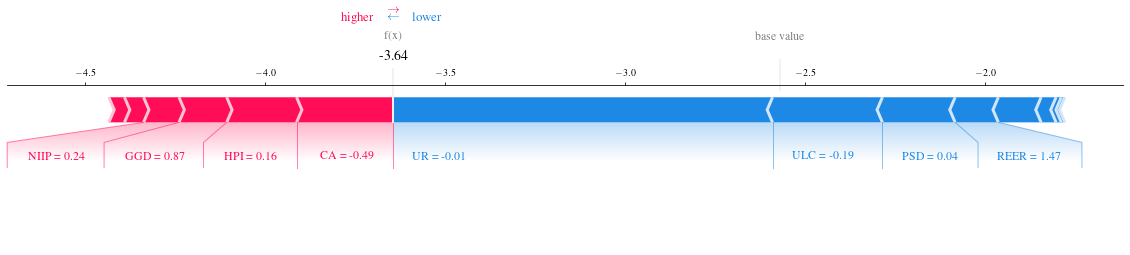

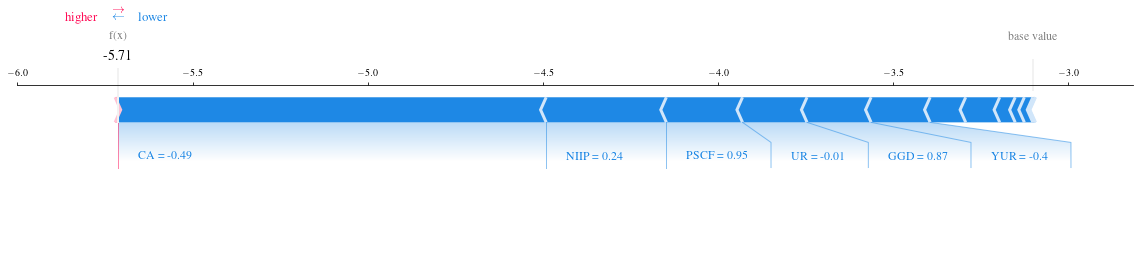

In [24]:
for mip in range(4):
    shap.force_plot(explainer.expected_value[mip],
                    shap_values[mip][y.index=='2018_FR'], 
                    X_shap.loc['2018_FR'].round(2), 
                    show=True, matplotlib=True)

<br>